## 이전 N -t 시간을 고려한 Logistic Regression

In [3]:
from math import sqrt
from pandas import read_csv
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from keras.models import Sequential
from keras.layers import Dense, LSTM

import datetime as dt
import pandas as pd
import numpy as np
import os

Using TensorFlow backend.


In [281]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### shift 를 활용한 데이터 만들기

In [15]:
debug = True

In [204]:
def series_to_timeseries(data, x_features, n_step=6):
    # convert series to supervised learning
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()

    # debug
    if debug:
        print('n_vars = {}, df.shape = {}'.format(n_vars, df.shape))

    # input sequence (t-n, ... t-1)
    for i in range(n_step, -1, -1):
        cols.append(df.shift(i))
        names += [('{}_t{}'.format(j, i)) for j in x_features]

    # forecast sequence (t, t+1, ... t+n)
    #for i in range(0, n_out):
    #    cols.append(df.shift(-i))
    #    if i == 0:
    #        names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
    #    else:
    #        names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]

    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names

    return agg 

### data loading

In [244]:
FILENAME = 'FZ_Data/FZ_all_ffill.csv'

if not os.path.exists(FILENAME):
    assert False, 'cannot find FILENAME: {}'.format(FILENAME)
else:
    print('found : {}'.format(FILENAME))

found : FZ_Data/FZ_all_ffill.csv


In [245]:
if FILENAME.endswith('.xlsx'):
    df = pd.read_excel(FILENAME, 
                       header=0,
                       encoding='euc-kr',
                       converters={'지점':str, '지면상태(지면상태코드)':str, '현상번호(국내식)':str})
elif FILENAME.endswith('.csv'):
    df = pd.read_csv(FILENAME, 
                     header=0,
                     encoding='euc-kr',
                     converters={'지점':str, '지면상태(지면상태코드)':str, '현상번호(국내식)':str})

In [246]:
use_colmns = ['지점', '지점명', '일시', '기온(°C)', '강수량(mm)', 
       '풍속(m/s)', '풍향(16방위)', '습도(%)', 
       '증기압(hPa)', '이슬점온도(°C)', '현지기압(hPa)', '해면기압(hPa)',
       '일조(hr)', '일사(MJ/m2)', '적설(cm)', '3시간신적설(cm)',
       '전운량(10분위)', '중하층운량(10분위)', '운형(운형약어)', '최저운고(100m )', '시정(10m)',
       '지면상태(지면상태코드)', '현상번호(국내식)', '지면온도(°C)',
       'FZ_flag']

df = df[use_colmns]

In [247]:
df.rename(columns = {'지점' : 'Office',
                      '지점명' : 'Office_Name',
                      '일시' : 'Date',
                      '기온(°C)': 'Temp', 
                      '강수량(mm)': 'Rain', 
                      '풍속(m/s)': 'WindSpeed', 
                      '풍향(16방위)': 'WindDir',  
                      '습도(%)': 'Moist',
                      '증기압(hPa)': 'hPa', 
                      '이슬점온도(°C)': 'DewTemp', 
                      '현지기압(hPa)': 'CurhPa', 
                      '해면기압(hPa)': 'SeahPa',
                      '일조(hr)': 'Daylight', 
                      '일사(MJ/m2)': 'DaylightMJ', 
                      '적설(cm)': 'SnowCm', 
                      '3시간신적설(cm)': 'Snow3hr',
                      '전운량(10분위)': 'Clouds_10', 
                      '중하층운량(10분위)': 'MClouds_10',                      
                      '운형(운형약어)' : 'CloudDesigns_Abb',                     
                      '최저운고(100m )': 'HClouds_100m', 
                      '시정(10m)': 'Visibility_10m', 
                      '지면상태(지면상태코드)': 'GroundState_Code',
                      '현상번호(국내식)': 'PhenomenaNo',
                      '지면온도(°C)': 'SurfaceTemp'
                     }, inplace=True)

In [248]:
df.columns

Index(['Office', 'Office_Name', 'Date', 'Temp', 'Rain', 'WindSpeed', 'WindDir',
       'Moist', 'hPa', 'DewTemp', 'CurhPa', 'SeahPa', 'Daylight', 'DaylightMJ',
       'SnowCm', 'Snow3hr', 'Clouds_10', 'MClouds_10', 'CloudDesigns_Abb',
       'HClouds_100m', 'Visibility_10m', 'GroundState_Code', 'PhenomenaNo',
       'SurfaceTemp', 'FZ_flag'],
      dtype='object')

In [249]:
x_features = ['Temp', 'Rain', 'WindSpeed', 'WindDir',
       'Moist', 'hPa', 'DewTemp', 'CurhPa', 'SeahPa', 'Daylight', 'DaylightMJ',
       'SnowCm', 'Snow3hr', 'Clouds_10', 'MClouds_10', 'CloudDesigns_Abb',
       'HClouds_100m', 'Visibility_10m', 'GroundState_Code', 'PhenomenaNo',
       'SurfaceTemp']

In [250]:
df_x_features = df[x_features]

In [251]:
N_STEP=3

In [252]:
reframed = series_to_timeseries(df_x_features, x_features, n_step=N_STEP)

n_vars = 21, df.shape = (29015, 21)


In [253]:
reframed.columns

Index(['Temp_t3', 'Rain_t3', 'WindSpeed_t3', 'WindDir_t3', 'Moist_t3',
       'hPa_t3', 'DewTemp_t3', 'CurhPa_t3', 'SeahPa_t3', 'Daylight_t3',
       'DaylightMJ_t3', 'SnowCm_t3', 'Snow3hr_t3', 'Clouds_10_t3',
       'MClouds_10_t3', 'CloudDesigns_Abb_t3', 'HClouds_100m_t3',
       'Visibility_10m_t3', 'GroundState_Code_t3', 'PhenomenaNo_t3',
       'SurfaceTemp_t3', 'Temp_t2', 'Rain_t2', 'WindSpeed_t2', 'WindDir_t2',
       'Moist_t2', 'hPa_t2', 'DewTemp_t2', 'CurhPa_t2', 'SeahPa_t2',
       'Daylight_t2', 'DaylightMJ_t2', 'SnowCm_t2', 'Snow3hr_t2',
       'Clouds_10_t2', 'MClouds_10_t2', 'CloudDesigns_Abb_t2',
       'HClouds_100m_t2', 'Visibility_10m_t2', 'GroundState_Code_t2',
       'PhenomenaNo_t2', 'SurfaceTemp_t2', 'Temp_t1', 'Rain_t1',
       'WindSpeed_t1', 'WindDir_t1', 'Moist_t1', 'hPa_t1', 'DewTemp_t1',
       'CurhPa_t1', 'SeahPa_t1', 'Daylight_t1', 'DaylightMJ_t1', 'SnowCm_t1',
       'Snow3hr_t1', 'Clouds_10_t1', 'MClouds_10_t1', 'CloudDesigns_Abb_t1',
       'HClouds_1

In [254]:
reframed.head()

,Temp_t3,Rain_t3,WindSpeed_t3,WindDir_t3,Moist_t3,hPa_t3,DewTemp_t3,CurhPa_t3,SeahPa_t3,Daylight_t3,...,SnowCm_t0,Snow3hr_t0,Clouds_10_t0,MClouds_10_t0,CloudDesigns_Abb_t0,HClouds_100m_t0,Visibility_10m_t0,GroundState_Code_t0,PhenomenaNo_t0,SurfaceTemp_t0
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,4.0,4.0,Sc,4.0,1200.0,,,-5.3
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,4.0,4.0,Sc,4.0,1200.0,,,-5.3
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,4.0,4.0,Sc,4.0,1200.0,,,-5.3
3,-5.7,0.0,4.2,270.0,96.0,3.6,-7.0,924.6,1028.3,0.0,...,1.0,0.0,4.0,4.0,Sc,4.0,1200.0,16,,-5.3
4,-5.4,0.0,5.0,270.0,97.0,3.6,-7.0,924.6,1028.3,0.0,...,1.0,0.0,4.0,4.0,Sc,4.0,1200.0,,,-5.3


In [255]:
reframed.shape

(29015, 84)

In [256]:
df_head = df[['Office', 'Office_Name', 'Date']]
df_tail = df[['FZ_flag']]

In [257]:
df_reframed = pd.concat([df_head, reframed, df_tail], axis=1)

In [258]:
df_reframed.shape

(29015, 88)

In [259]:
df_reframed.head()

,Office,Office_Name,Date,Temp_t3,Rain_t3,WindSpeed_t3,WindDir_t3,Moist_t3,hPa_t3,DewTemp_t3,...,Snow3hr_t0,Clouds_10_t0,MClouds_10_t0,CloudDesigns_Abb_t0,HClouds_100m_t0,Visibility_10m_t0,GroundState_Code_t0,PhenomenaNo_t0,SurfaceTemp_t0,FZ_flag
0,100,대관령,2006-01-01 0:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,4.0,4.0,Sc,4.0,1200.0,,,-5.3,0
1,100,대관령,2006-01-01 1:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,4.0,4.0,Sc,4.0,1200.0,,,-5.3,0
2,100,대관령,2006-01-01 2:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,4.0,4.0,Sc,4.0,1200.0,,,-5.3,0
3,100,대관령,2006-01-01 3:00,-5.7,0.0,4.2,270.0,96.0,3.6,-7.0,...,0.0,4.0,4.0,Sc,4.0,1200.0,16,,-5.3,0
4,100,대관령,2006-01-01 4:00,-5.4,0.0,5.0,270.0,97.0,3.6,-7.0,...,0.0,4.0,4.0,Sc,4.0,1200.0,,,-5.3,0


In [260]:
df_reframed.isnull().sum()

Office                 0
Office_Name            0
Date                   0
Temp_t3                3
Rain_t3                3
                      ..
Visibility_10m_t0      0
GroundState_Code_t0    0
PhenomenaNo_t0         0
SurfaceTemp_t0         0
FZ_flag                0
Length: 88, dtype: int64

In [261]:
df_reframed.dropna(inplace=True)

In [262]:
df_reframed.isnull().sum()

Office                 0
Office_Name            0
Date                   0
Temp_t3                0
Rain_t3                0
                      ..
Visibility_10m_t0      0
GroundState_Code_t0    0
PhenomenaNo_t0         0
SurfaceTemp_t0         0
FZ_flag                0
Length: 88, dtype: int64

In [263]:
df_reframed.shape

(29012, 88)

In [264]:
df_reframed.to_csv('FZ_Data/FZ_all_reframed.csv', index=False, encoding='euc-kr')

## correlation

In [265]:
df_reframed.corr()

,Temp_t3,Rain_t3,WindSpeed_t3,WindDir_t3,Moist_t3,hPa_t3,DewTemp_t3,CurhPa_t3,SeahPa_t3,Daylight_t3,...,Daylight_t0,DaylightMJ_t0,SnowCm_t0,Snow3hr_t0,Clouds_10_t0,MClouds_10_t0,HClouds_100m_t0,Visibility_10m_t0,SurfaceTemp_t0,FZ_flag
Temp_t3,1.000000,0.036705,0.024778,-0.024769,-0.197167,0.701217,0.724685,0.222100,-0.467331,0.186530,...,-0.096390,-0.057245,-0.320558,-0.023226,0.256917,0.212277,0.072722,-0.121960,0.819003,-0.031620
Rain_t3,0.036705,1.000000,-0.006564,-0.038183,0.131083,0.129696,0.112518,-0.031900,-0.104234,-0.058663,...,-0.050583,-0.024873,0.067453,0.301643,0.126837,0.125108,-0.055168,-0.122592,0.027276,-0.004974
WindSpeed_t3,0.024778,-0.006564,1.000000,0.413647,-0.265917,-0.113603,-0.138710,-0.412300,-0.368677,0.228788,...,0.064094,0.183310,0.060426,-0.003118,-0.097964,-0.043827,-0.156598,0.108538,0.011411,-0.039531
WindDir_t3,-0.024769,-0.038183,0.413647,1.000000,-0.301478,-0.177416,-0.208352,-0.103312,-0.170033,0.148255,...,0.063866,0.058329,-0.005628,-0.027637,-0.196044,-0.161901,-0.027040,0.181587,-0.007287,-0.035591
Moist_t3,-0.197167,0.131083,-0.265917,-0.301478,1.000000,0.467273,0.503049,-0.237053,-0.001828,-0.523608,...,-0.164958,-0.080031,0.159496,0.083039,0.362196,0.403052,-0.251494,-0.634448,-0.200155,0.052640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MClouds_10_t0,0.212277,0.125108,-0.043827,-0.161901,0.403052,0.434972,0.445789,-0.063654,-0.249275,-0.283120,...,-0.302614,-0.122625,0.050589,0.101584,0.823266,1.000000,-0.088316,-0.523750,0.165464,0.069706
HClouds_100m_t0,0.072722,-0.055168,-0.156598,-0.027040,-0.251494,-0.092597,-0.100068,0.391001,0.105193,0.047708,...,0.030333,-0.030205,-0.111882,-0.052895,-0.056801,-0.088316,1.000000,0.208345,0.058830,-0.038563
Visibility_10m_t0,-0.121960,-0.122592,0.108538,0.181587,-0.634448,-0.491829,-0.528197,0.165538,0.230029,0.376728,...,0.293733,0.120955,-0.085198,-0.119285,-0.513472,-0.523750,0.208345,1.000000,-0.017078,-0.078420
SurfaceTemp_t0,0.819003,0.027276,0.011411,-0.007287,-0.200155,0.549653,0.552719,0.210360,-0.364904,0.320441,...,0.098638,0.062238,-0.191770,-0.021246,0.197860,0.165464,0.058830,-0.017078,1.000000,-0.019208


In [266]:
df_sorted = df_reframed.corr()['FZ_flag'][:-1].sort_values(ascending=False)

In [282]:
df_sorted

MClouds_10_t0        0.069706
MClouds_10_t1        0.057073
Moist_t0             0.056129
Moist_t1             0.054322
Moist_t2             0.053268
Moist_t3             0.052640
Clouds_10_t0         0.046000
MClouds_10_t2        0.045511
Clouds_10_t1         0.037635
MClouds_10_t3        0.036090
Clouds_10_t2         0.029448
Clouds_10_t3         0.022328
SeahPa_t0            0.022318
SeahPa_t1            0.021834
SnowCm_t0            0.021277
SeahPa_t2            0.020747
SeahPa_t3            0.019879
SnowCm_t1            0.017841
SnowCm_t2            0.013895
SnowCm_t3            0.010677
DewTemp_t3           0.001390
DewTemp_t2          -0.001322
DewTemp_t1          -0.003082
DewTemp_t0          -0.003212
Snow3hr_t0          -0.003466
Snow3hr_t3          -0.003466
Snow3hr_t2          -0.003466
Snow3hr_t1          -0.003466
Rain_t0             -0.003908
Rain_t2             -0.004669
Rain_t1             -0.004669
Rain_t3             -0.004974
hPa_t3              -0.005598
hPa_t2    

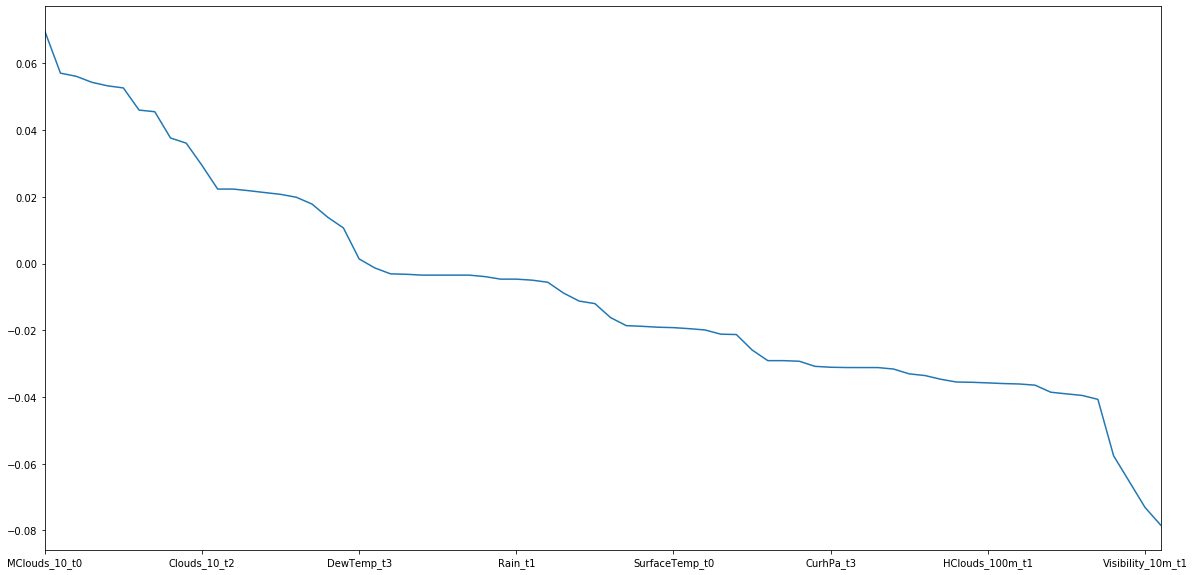

In [279]:
df_sorted.plot(figsize=(20,10))

### use Logistic Regression with reframed

In [269]:
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm

In [270]:
def build_formula(x_list, n_step, y):
    names = list()
    for i in range(n_step, -1, -1):
        names += [('{}_t{}'.format(j, i)) for j in x_features]
        
    x_str = ' + '.join(names)
    return '{} ~ {}'.format(y, x_str)

In [283]:
x_features = ['Temp', 'Rain', 'WindSpeed', 'WindDir',
       'Moist', 'hPa', 'DewTemp', 'CurhPa', 'SeahPa', 'Daylight', 'DaylightMJ',
       'SnowCm', 'Snow3hr', 'Clouds_10', 'MClouds_10', 
       'HClouds_100m', 'Visibility_10m',  'SurfaceTemp']
y_column = 'FZ_flag'

In [284]:
fm_str = build_formula(x_features, n_step=N_STEP, y=y_column)

In [285]:
fm_str

'FZ_flag ~ Temp_t3 + Rain_t3 + WindSpeed_t3 + WindDir_t3 + Moist_t3 + hPa_t3 + DewTemp_t3 + CurhPa_t3 + SeahPa_t3 + Daylight_t3 + DaylightMJ_t3 + SnowCm_t3 + Snow3hr_t3 + Clouds_10_t3 + MClouds_10_t3 + HClouds_100m_t3 + Visibility_10m_t3 + SurfaceTemp_t3 + Temp_t2 + Rain_t2 + WindSpeed_t2 + WindDir_t2 + Moist_t2 + hPa_t2 + DewTemp_t2 + CurhPa_t2 + SeahPa_t2 + Daylight_t2 + DaylightMJ_t2 + SnowCm_t2 + Snow3hr_t2 + Clouds_10_t2 + MClouds_10_t2 + HClouds_100m_t2 + Visibility_10m_t2 + SurfaceTemp_t2 + Temp_t1 + Rain_t1 + WindSpeed_t1 + WindDir_t1 + Moist_t1 + hPa_t1 + DewTemp_t1 + CurhPa_t1 + SeahPa_t1 + Daylight_t1 + DaylightMJ_t1 + SnowCm_t1 + Snow3hr_t1 + Clouds_10_t1 + MClouds_10_t1 + HClouds_100m_t1 + Visibility_10m_t1 + SurfaceTemp_t1 + Temp_t0 + Rain_t0 + WindSpeed_t0 + WindDir_t0 + Moist_t0 + hPa_t0 + DewTemp_t0 + CurhPa_t0 + SeahPa_t0 + Daylight_t0 + DaylightMJ_t0 + SnowCm_t0 + Snow3hr_t0 + Clouds_10_t0 + MClouds_10_t0 + HClouds_100m_t0 + Visibility_10m_t0 + SurfaceTemp_t0'

In [286]:
model_all = sm.Logit.from_formula(fm_str, df_reframed)

In [300]:
result = model_all.fit(maxiter=800, method='bfgs')

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1789: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1789: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: 0.005948
         Iterations: 761
         Function evaluations: 800
         Gradient evaluations: 796


In [301]:
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                             Results: Logit
========================================================================
Model:                 Logit              Pseudo R-squared:   0.645     
Dependent Variable:    FZ_flag            AIC:                491.1247  
Date:                  2020-02-13 17:10   BIC:                1095.2336 
No. Observations:      29012              Log-Likelihood:     -172.56   
Df Model:              72                 LL-Null:            -485.77   
Df Residuals:          28939              LLR p-value:        2.3238e-89
Converged:             1.0000             Scale:              1.0000    
------------------------------------------------------------------------
                   Coef.    Std.Err.    z    P>|z|    [0.025     0.975] 
------------------------------------------------------------------------
Intercept           6.6306   36.9107  0.1796 0.8574   -65.7132   78.9743
Temp_t3             1.1757    0.3390  3.4686 0.0005     0.5114    1.8401
Rain_t3           -18.7543   57.4158 -0.3266 0.7439  -131.2872   93.7786
WindSpeed_t3       -0.2564    0.2903 -0.8835 0.3770    -0.8253    0.3125
WindDir_t3         -0.0005    0.0015 -0.3566 0.7214    -0.0035    0.0024
Moist_t3            0.1771    0.0708  2.5017 0.0124     0.0383    0.3158
hPa_t3              2.8143    1.0214  2.7554 0.0059     0.8125    4.8162
DewTemp_t3         -0.9578    0.3534 -2.7102 0.0067    -1.6505   -0.2651
CurhPa_t3           0.7065    0.2003  3.5266 0.0004     0.3139    1.0992
SeahPa_t3          -0.2088    0.2483 -0.8409 0.4004    -0.6955    0.2779
Daylight_t3       -97.2547  223.9237 -0.4343 0.6641  -536.1371  341.6277
DaylightMJ_t3       3.8811    4.6579  0.8332 0.4047    -5.2483   13.0105
SnowCm_t3          -0.0471    0.0372 -1.2651 0.2058    -0.1201    0.0259
Snow3hr_t3        -17.4086  148.1947 -0.1175 0.9065  -307.8649  273.0477
Clouds_10_t3       -0.2090    0.1660 -1.2587 0.2081    -0.5344    0.1164
MClouds_10_t3       0.1814    0.1541  1.1770 0.2392    -0.1207    0.4835
HClouds_100m_t3    -0.0271    0.0629 -0.4298 0.6673    -0.1504    0.0963
Visibility_10m_t3   0.0019    0.0008  2.4691 0.0135     0.0004    0.0033
SurfaceTemp_t3     -0.5562    0.2067 -2.6908 0.0071    -0.9613   -0.1511
Temp_t2             0.2254    0.4435  0.5083 0.6113    -0.6439    1.0948
Rain_t2             0.1178    0.9043  0.1303 0.8963    -1.6545    1.8902
WindSpeed_t2       -0.5518    0.3225 -1.7111 0.0871    -1.1838    0.0803
WindDir_t2          0.0000    0.0015  0.0127 0.9898    -0.0030    0.0031
Moist_t2           -0.0127    0.0863 -0.1477 0.8826    -0.1818    0.1563
hPa_t2              2.0907    1.2387  1.6878 0.0914    -0.3371    4.5184
DewTemp_t2         -1.1298    0.4289 -2.6343 0.0084    -1.9704   -0.2892
CurhPa_t2          -0.0052    0.2950 -0.0178 0.9858    -0.5835    0.5730
SeahPa_t2          -0.2069    0.3494 -0.5923 0.5536    -0.8917    0.4778
Daylight_t2       -80.3762 1126.9555 -0.0713 0.9431 -2289.1684 2128.4159
DaylightMJ_t2      -7.3752    8.0150 -0.9202 0.3575   -23.0843    8.3340
SnowCm_t2          -0.0033    0.0373 -0.0876 0.9302    -0.0765    0.0699
Snow3hr_t2        -39.3577   69.5607 -0.5658 0.5715  -175.6942   96.9787
Clouds_10_t2       -0.0434    0.2127 -0.2042 0.8382    -0.4602    0.3734
MClouds_10_t2       0.0054    0.2099  0.0255 0.9796    -0.4061    0.4168
HClouds_100m_t2    -0.0674    0.1091 -0.6180 0.5366    -0.2812    0.1464
Visibility_10m_t2   0.0002    0.0010  0.1544 0.8773    -0.0018    0.0021
SurfaceTemp_t2      0.1410    0.2659  0.5303 0.5959    -0.3802    0.6622
Temp_t1            -0.1101    0.4187 -0.2630 0.7926    -0.9307    0.7105
Rain_t1             0.1986    0.5375  0.3694 0.7118    -0.8550    1.2521
WindSpeed_t1       -0.2269    0.2998 -0.7569 0.4491    -0.8146    0.3607
WindDir_t1         -0.0004    0.0015 -0.2591 0.7956    -0.0034    0.0026
Moist_t1           -0.0565    0.0732 -0.7723 0.4400    -0.1999    0.0869
hPa_t1             -2.5344    1.6667 -